<a href="https://colab.research.google.com/github/Goro-python/my_NLP/blob/next_dev/SNLI_benchmark_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!ls 

In [2]:
#!git clone https://github.com/Smerity/keras_snli.git

In [3]:
#!ls

In [4]:
#!ls keras_snli

In [5]:
#!python3 keras_snli/snli_rnn.py

In [6]:
#!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
#
#!ls

--2020-12-26 13:06:13--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-12-26 13:06:13--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-12-26 13:06:13--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [8]:
#!unzip -q glove.840B.300d.zip

In [9]:
!ls

glove.840B.300d.txt  glove.840B.300d.zip  sample_data


In [10]:
#!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip

--2020-12-26 13:33:05--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94550081 (90M) [application/zip]
Saving to: ‘snli_1.0.zip’

snli_1.0.zip        100%[===================>]  90.17M  26.5MB/s    in 3.6s    

2020-12-26 13:33:09 (25.0 MB/s) - ‘snli_1.0.zip’ saved [94550081/94550081]



In [11]:
#!unzip -q snli_1.0.zip

In [21]:
# getting data 
from __future__ import print_function
from functools import reduce
import json
import os
import re
import tarfile
import tempfile

import numpy as np
np.random.seed(1337)  # for reproducibility


import keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import merge, recurrent, Dense, Input, Dropout, TimeDistributed,concatenate
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from keras.utils import np_utils


In [22]:
def extract_tokens_from_binary_parse(parse):
    return parse.replace('(', ' ').replace(')', ' ').replace('-LRB-', '(').replace('-RRB-', ')').split()

def yield_examples(fn, skip_no_majority=True, limit=None):
  for i, line in enumerate(open(fn)):
    if limit and i > limit:
      break
    data = json.loads(line)
    label = data['gold_label']
    s1 = ' '.join(extract_tokens_from_binary_parse(data['sentence1_binary_parse']))
    s2 = ' '.join(extract_tokens_from_binary_parse(data['sentence2_binary_parse']))
    if skip_no_majority and label == '-':
      continue
    yield (label, s1, s2)

def get_data(fn, limit=None):
  raw_data = list(yield_examples(fn=fn, limit=limit))
  left = [s1 for _, s1, s2 in raw_data]
  right = [s2 for _, s1, s2 in raw_data]
  print(max(len(x.split()) for x in left))
  print(max(len(x.split()) for x in right))

  LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
  Y = np.array([LABELS[l] for l, s1, s2 in raw_data])
  Y = np_utils.to_categorical(Y, len(LABELS))

  return left, right, Y

training = get_data('snli_1.0/snli_1.0_train.jsonl')
validation = get_data('snli_1.0/snli_1.0_dev.jsonl')
test = get_data('snli_1.0/snli_1.0_test.jsonl')

82
62
59
55
57
30


In [23]:
tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(training[0] + training[1])

# Lowest index from the tokenizer is 1 - we need to include 0 in our vocab count
VOCAB = len(tokenizer.word_counts) + 1
LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
#RNN = recurrent.LSTM
#RNN = lambda *args, **kwargs: Bidirectional(recurrent.LSTM(*args, **kwargs))
#RNN = recurrent.GRU
#RNN = lambda *args, **kwargs: Bidirectional(recurrent.GRU(*args, **kwargs))
# Summation of word embeddings
RNN = None
LAYERS = 1
USE_GLOVE = True
TRAIN_EMBED = False
EMBED_HIDDEN_SIZE = 300
SENT_HIDDEN_SIZE = 300
BATCH_SIZE = 512
PATIENCE = 4 # 8
MAX_EPOCHS = 42
MAX_LEN = 42
DP = 0.2
L2 = 4e-6
ACTIVATION = 'relu'
OPTIMIZER = 'rmsprop'
print('RNN / Embed / Sent = {}, {}, {}'.format(RNN, EMBED_HIDDEN_SIZE, SENT_HIDDEN_SIZE))
print('GloVe / Trainable Word Embeddings = {}, {}'.format(USE_GLOVE, TRAIN_EMBED))

to_seq = lambda X: pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_LEN)
prepare_data = lambda data: (to_seq(data[0]), to_seq(data[1]), data[2])

training = prepare_data(training)
validation = prepare_data(validation)
test = prepare_data(test)

print('Build model...')
print('Vocab size =', VOCAB)

GLOVE_STORE = 'precomputed_glove.weights'
if USE_GLOVE:
  if not os.path.exists(GLOVE_STORE + '.npy'):
    print('Computing GloVe')
  
    embeddings_index = {}
    f = open('glove.840B.300d.txt')
    for line in f:
      values = line.split(' ')
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    f.close()
    
    # prepare embedding matrix
    embedding_matrix = np.zeros((VOCAB, EMBED_HIDDEN_SIZE))
    for word, i in tokenizer.word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
      else:
        print('Missing from GloVe: {}'.format(word))
  
    np.save(GLOVE_STORE, embedding_matrix)

  print('Loading GloVe')
  embedding_matrix = np.load(GLOVE_STORE + '.npy')

  print('Total number of null word embeddings:')
  print(np.sum(np.sum(embedding_matrix, axis=1) == 0))

  embed = Embedding(VOCAB, EMBED_HIDDEN_SIZE, weights=[embedding_matrix], input_length=MAX_LEN, trainable=TRAIN_EMBED)
else:
  embed = Embedding(VOCAB, EMBED_HIDDEN_SIZE, input_length=MAX_LEN)

RNN / Embed / Sent = None, 300, 300
GloVe / Trainable Word Embeddings = True, False
Build model...
Vocab size = 42391
Loading GloVe
Total number of null word embeddings:
4043


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 300)      12717300    input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 42, 300)      90300       embedding_1[4][0]          

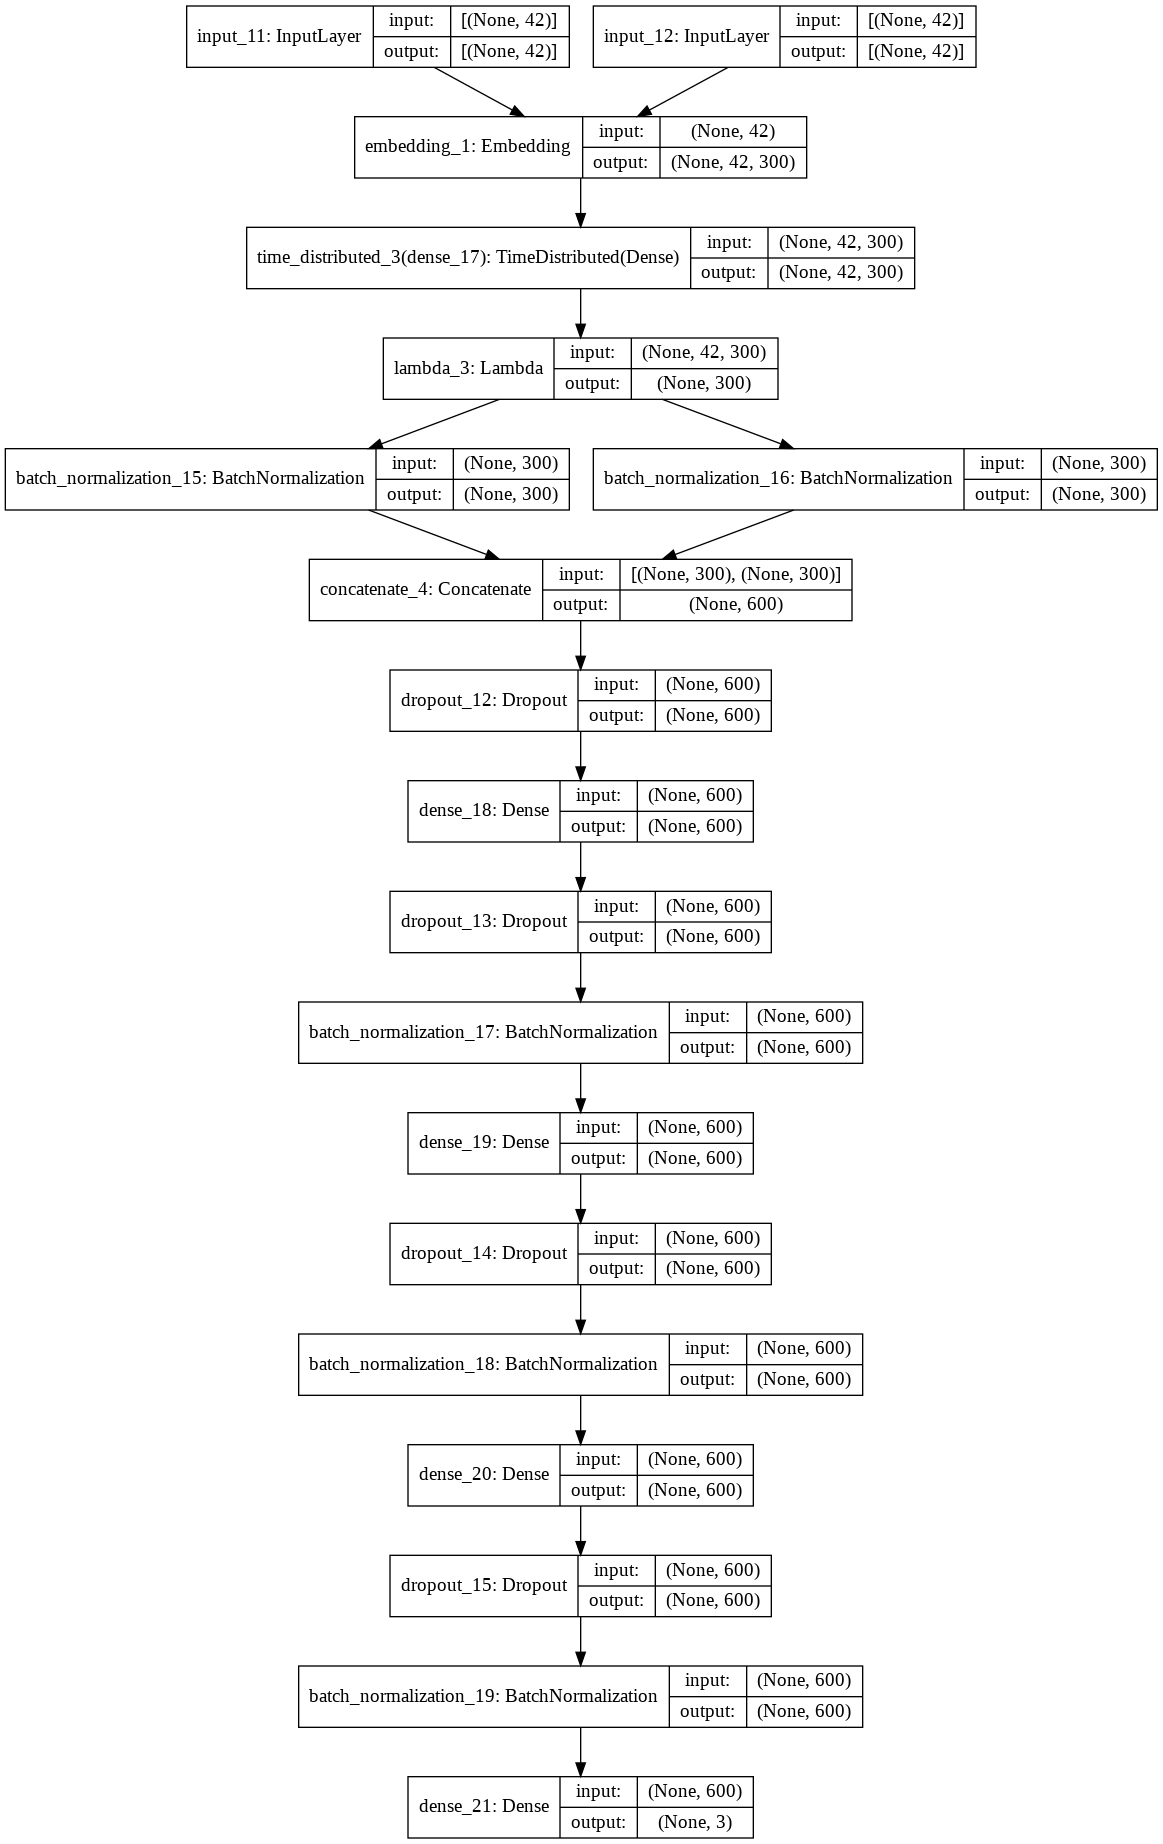

In [45]:
rnn_kwargs = dict(output_dim=SENT_HIDDEN_SIZE, dropout_W=DP, dropout_U=DP)
SumEmbeddings = keras.layers.core.Lambda(lambda x: K.sum(x, axis=1), output_shape=(SENT_HIDDEN_SIZE, ))

translate = TimeDistributed(Dense(SENT_HIDDEN_SIZE, activation=ACTIVATION))

premise = Input(shape=(MAX_LEN,), dtype='int32')
hypothesis = Input(shape=(MAX_LEN,), dtype='int32')

prem = embed(premise)
hypo = embed(hypothesis)

prem = translate(prem)
hypo = translate(hypo)

if RNN and LAYERS > 1:
  for l in range(LAYERS - 1):
    rnn = RNN(return_sequences=True, **rnn_kwargs)
    prem = BatchNormalization()(rnn(prem))
    hypo = BatchNormalization()(rnn(hypo))
rnn = SumEmbeddings if not RNN else RNN(return_sequences=False, **rnn_kwargs)
prem = rnn(prem)
hypo = rnn(hypo)
prem = BatchNormalization()(prem)
hypo = BatchNormalization()(hypo)

joint = concatenate([prem, hypo])
joint = Dropout(DP)(joint)
for i in range(3):
  joint = Dense(2 * SENT_HIDDEN_SIZE, activation=ACTIVATION)(joint)
  joint = Dropout(DP)(joint)
  joint = BatchNormalization()(joint)

pred = Dense(len(LABELS), activation='softmax')(joint)

model = Model(inputs=[premise, hypothesis], outputs=pred)
model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# print('Training')
# _, tmpfn = tempfile.mkstemp()
# Save the best model during validation and bail out of training early if we're not improving
#callbacks = [EarlyStopping(patience=PATIENCE), ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)]
#model.fit([training[0][:50000], training[1][:50000]], training[2][:50000], batch_size=BATCH_SIZE, epochs=MAX_EPOCHS,validation_data=([validation[0], validation[1]], validation[2]))

keras.utils.plot_model(model,show_shapes=True)


In [27]:
# testing with my model 

In [ ]:
# Restore the best found model during validation
#model.load_weights(tmpfn)

# loss, acc = model.evaluate([test[0], test[1]], test[2], batch_size=BATCH_SIZE)
# print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

In [39]:
test[0].shape

(9824, 42)

In [42]:
# mu model 

import tensorflow as tf
import keras

In [90]:

embed_layer = Embedding(VOCAB, EMBED_HIDDEN_SIZE, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False)
SumEmbeddings = keras.layers.core.Lambda(lambda x: K.sum(x, axis=1), output_shape=(SENT_HIDDEN_SIZE, ))

inp1 = tf.keras.layers.Input(shape=(42,))
embed1 = embed_layer(inp1)
embed1 = tf.keras.layers.TimeDistributed(Dense(SENT_HIDDEN_SIZE, activation=ACTIVATION))(embed1)
embed1 = SumEmbeddings(embed1)
embed1 = tf.keras.layers.BatchNormalization()(embed1)
inp2 = tf.keras.layers.Input(shape=(42,))
embed2 = embed_layer(inp2)
embed2 = tf.keras.layers.TimeDistributed(Dense(SENT_HIDDEN_SIZE, activation=ACTIVATION))(embed2)
embed2 = SumEmbeddings(embed2)
embed2 = tf.keras.layers.BatchNormalization()(embed2)
concat = tf.keras.layers.concatenate([embed1,embed2])
#output = tf.keras.layers.GlobalMaxPooling1D()(concat)
output = tf.keras.layers.BatchNormalization()(concat)

output = tf.keras.layers.Dense(units = 600, activation = 'relu')(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.BatchNormalization()(output)

output = tf.keras.layers.Dense(units = 600, activation = 'relu')(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dense(units = 600, activation = 'relu')(output)

output = tf.keras.layers.Dense(units = 3, activation = 'softmax')(output)




my_model = keras.Model(inputs = [inp1,inp2],outputs = output)

keras.utils.plot_model(my_model,show_shapes=True)


print(my_model.summary())

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 42, 300)      12717300    input_44[0][0]                   
                                                                 input_45[0][0]                   
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 42, 300)      90300       embedding_23[0][0]        

In [92]:
my_model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])


my_model.fit([training[0], training[1]], training[2], batch_size=BATCH_SIZE, epochs=1,validation_data=([validation[0], validation[1]], validation[2]))

1073/1073 [==============================] - 25s 22ms/step - loss: 0.3428 - accuracy: 0.8674 - val_loss: 0.4962 - val_accuracy: 0.8230


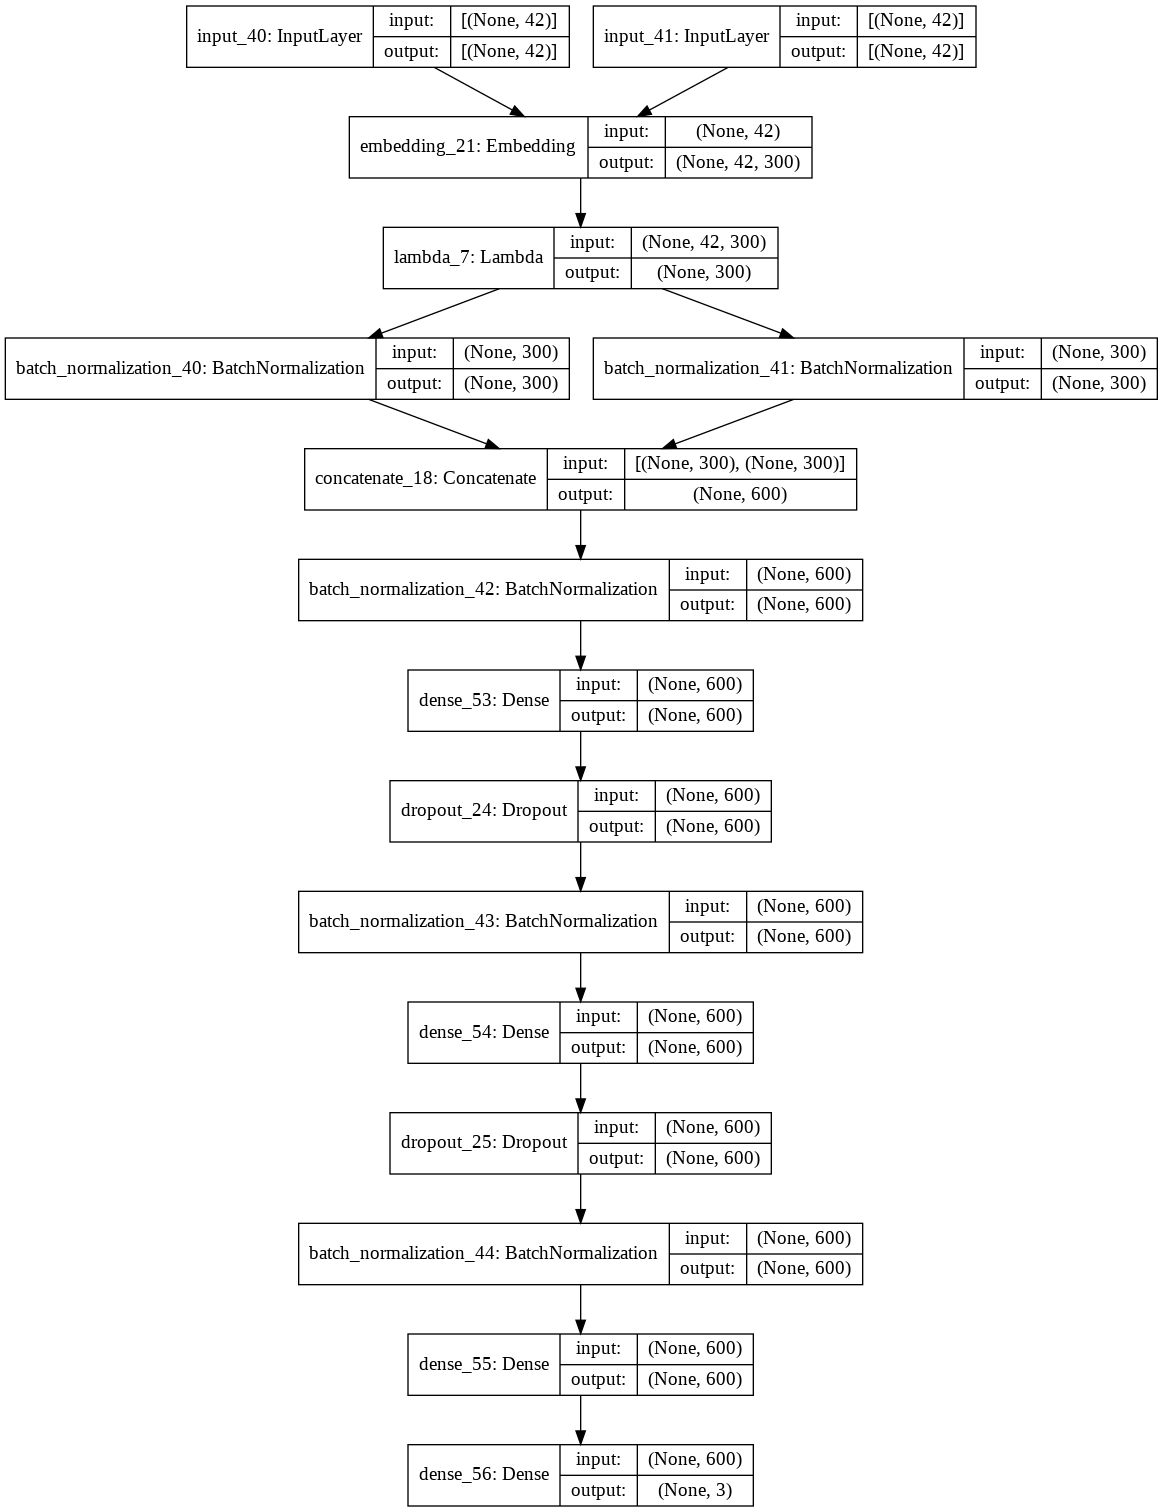

In [83]:

keras.utils.plot_model(my_model,show_shapes=True)

In [93]:
loss , acc = my_model.evaluate([test[0],test[1]],test[2],batch_size=128)

77/77 [==============================] - 0s 6ms/step - loss: 0.5095 - accuracy: 0.8187


In [97]:
my_model.save('my_model.h5')

In [98]:
!ls

glove.840B.300d.txt  model.png	  precomputed_glove.weights.npy  snli_1.0.zip
glove.840B.300d.zip  my_model	  sample_data
__MACOSX	     my_model.h5  snli_1.0
